In [110]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
from torchvision.io import read_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

import torchvision
model = torchvision.models.resnet18(pretrained=True)
model.eval()

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(denormalize(img).to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def denormalize(img):
    return img.to('cpu') * torch.Tensor([0.229, 0.224, 0.225]).view((3,1,1)) + torch.tensor([[0.485, 0.456, 0.406]]).view((3,1,1))

def prepare_plots(attr, img):
    img = denormalize(img).numpy().transpose((1,2,0)) * 255
    attr = attr.to('cpu').numpy().transpose((1,2,0))
    return attr, img

# Download an example image from the pytorch website
filename = "./data/dog.jpg"
if (not os.path.exists("./data/dog.jpg")):
    import urllib
    url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", filename)
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)

# Read the categories
with open("./data/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [111]:
# load other images
# https://github.com/EliSchwartz/imagenet-sample-images
    
def load_img(url):
    filename = "./data/" + url.split("/")[-1]
    print(filename)
    if (not os.path.exists(filename)):
        import urllib
        try: urllib.URLopener().retrieve(url, filename)
        except: urllib.request.urlretrieve(url, filename)
    image = Image.open(filename)
    input_image = preprocess(image)
    return input_image

git_path = "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/"

examples = [
    "n01443537_goldfish.JPEG",
    "n01532829_house_finch.JPEG",
    "n01491361_tiger_shark.JPEG",
    "n01622779_great_grey_owl.JPEG",
    "n01693334_green_lizard.JPEG",
    "n03662601_lifeboat.JPEG",
    "n03666591_lighter.JPEG",
    "n03691459_loudspeaker.JPEG",
    "n01742172_boa_constrictor.JPEG",
    "n01744401_rock_python.JPEG",
    "n01773797_garden_spider.JPEG",
]

other_images = [load_img(git_path + url) for url in examples]

./data/n01443537_goldfish.JPEG
./data/n01532829_house_finch.JPEG
./data/n01491361_tiger_shark.JPEG
./data/n01622779_great_grey_owl.JPEG
./data/n01693334_green_lizard.JPEG
./data/n03662601_lifeboat.JPEG
./data/n03666591_lighter.JPEG
./data/n03691459_loudspeaker.JPEG
./data/n01742172_boa_constrictor.JPEG
./data/n01744401_rock_python.JPEG
./data/n01773797_garden_spider.JPEG


In [86]:
from torch import nn

steps = 50

input_batch = input_image.unsqueeze(0) # create a mini-batch as expected by the model
label = torch.LongTensor([categories.index("Samoyed")] * (steps+1))

baseline = 0 * input_batch

if torch.cuda.is_available():
    baseline = baseline.to('cuda')
    input_batch = input_batch.to('cuda')

# Scale input and compute gradients.
scaled_inputs = [baseline + (float(i)/steps)*(input_batch-baseline) for i in range(0, steps+1)]
scaled_inputs = torch.cat(scaled_inputs)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    scaled_inputs = scaled_inputs.to('cuda')
    label = label.to('cuda')
    model.to('cuda')

# inference
scaled_inputs.requires_grad = True
output = model(scaled_inputs)

# get gradient for input
criterion = nn.CrossEntropyLoss()
criterion(output, label).backward()
grads = scaled_inputs.grad

# Use trapezoidal rule to approximate the integral.
# See Section 4 of the following paper for an accuracy comparison between
# left, right, and trapezoidal IG approximations:
# "Computing Linear Restrictions of Neural Networks", Matthew Sotoudeh, Aditya V. Thakur
# https://arxiv.org/abs/1908.06214
grads = (grads[:-1] + grads[1:]) / 2.0
avg_grads = grads.mean(0)
integrated_gradients = (input_batch-baseline) * avg_grads  # shape: <inp.shape>

In [87]:
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[-1], dim=0)

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.8371971845626831
white wolf 0.06099937856197357
keeshond 0.039010610431432724
Pomeranian 0.02333681285381317
Arctic fox 0.013027846813201904


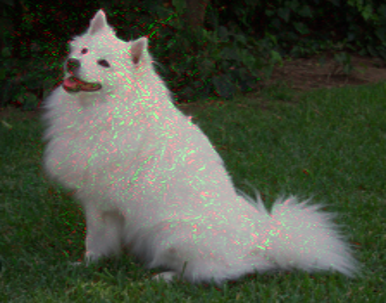

In [88]:
from VisualizationLibrary.visualization_lib import Visualize, show_pil_image, pil_image

pil_image(Visualize(
    *prepare_plots(integrated_gradients[0], input_image),
    polarity="both",
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=True)).resize((v//4 for v in image.size))

torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


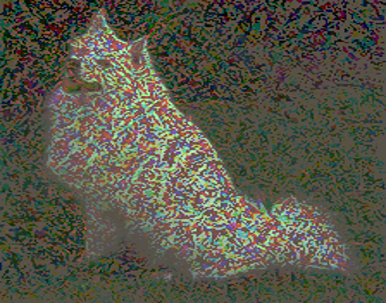

In [105]:
explanation = integrated_gradients[0]
input_image_w_gradient = input_image.clone()
print(input_image.shape, explanation.shape)
input_image_w_gradient[explanation < 10e-6] = 0


pil_image(Visualize(
    *prepare_plots(explanation, input_image_w_gradient),
    polarity="both",
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=True)).resize((v//4 for v in image.size))

torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


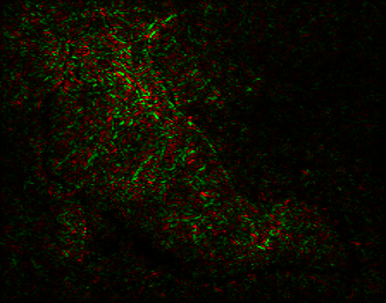

In [109]:
explanation = integrated_gradients[0]
input_image_w_gradient = input_image.clone()
print(input_image.shape, explanation.shape)
input_image_w_gradient[explanation < 0] = 0

pil_image(Visualize(
    *prepare_plots(explanation, input_image_w_gradient),
    polarity="both",
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=False)).resize((v//4 for v in image.size))